# Example of simulated component separation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 16

import healpy as hp
import pysm

from fgbuster.pysm_helpers import get_instrument, get_sky  # Predefined instrumental and sky-creation configurations
from fgbuster.visualization import corner_norm

# Imports needed for component separation
from fgbuster import (CMB, Dust, Synchrotron,  # sky-fitting model
                      basic_comp_sep)  # core routines

## Input frequency maps
You have some frequency maps to clean, they can be either data or simulations.

### Simple case
Let's simulate a simple sky with `pysm`. ForeGroundBuster adds a couple of functions that make the process even easier.

In [3]:
NSIDE = 64
sky_conf_simple = get_sky(NSIDE, 'c1d0s0') 
instrument = pysm.Instrument(get_instrument(NSIDE, 'cmbs4'))
freq_maps_simple, noise = instrument.observe(pysm.Sky(sky_conf_simple), write_outputs=False)

nu (GHz) | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) 

0020.00 | 16.66 | 13.60 | 00.00 
0030.00 | 10.62 | 08.67 | 00.00 
0040.00 | 10.07 | 08.22 | 00.00 
0085.00 | 02.01 | 01.64 | 00.00 
0095.00 | 01.59 | 01.30 | 00.00 
0145.00 | 04.53 | 02.03 | 00.00 
0155.00 | 04.53 | 02.03 | 00.00 
0220.00 | 11.61 | 05.19 | 00.00 
0270.00 | 15.84 | 07.08 | 00.00 
Instrument attribute 'pixel_indices' not set.


We will focus on polarization-only component separation

In [4]:
freq_maps_simple = freq_maps_simple[:, 1:]  # Select polarization

### Spatially varying spectral indices
Let's prepare also maps with spatially varying spectral indices. Similarly to the simple case above we run the following (notice `d1s1`)

In [5]:
NSIDE_PATCH = 8
sky_conf_vary = get_sky(NSIDE, 'c1d1s1')

We can still modify the sky configuration. In this case, we change the nside over which the spectral indices are allowed to vary

In [6]:
for comp, param in [('dust', 'spectral_index'),
                    ('dust', 'temp'),
                    ('synchrotron', 'spectral_index')
                   ]:
    spectral_param = sky_conf_vary[comp][0][param]
    spectral_param[:] = hp.ud_grade(hp.ud_grade(spectral_param, NSIDE_PATCH),
                                    NSIDE)

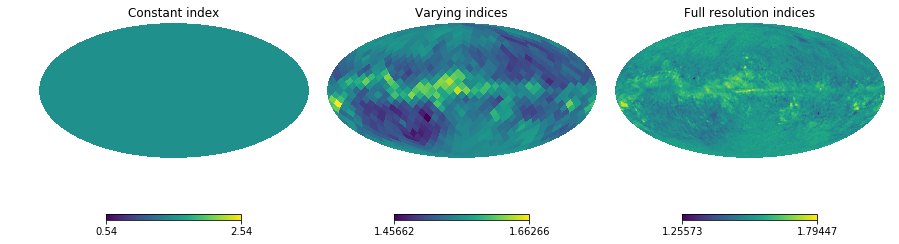

In [7]:
comp = 'dust'
param = 'spectral_index'
hp.mollview(sky_conf_simple[comp][0][param], sub=(1,3,1), title='Constant index')
hp.mollview(sky_conf_vary[comp][0][param], sub=(1,3,2), title='Varying indices')
hp.mollview(get_sky(NSIDE, 'c1d1s1')[comp][0][param], sub=(1,3,3), title='Full resolution indices')

In [8]:
freq_maps_vary, _ = instrument.observe(pysm.Sky(sky_conf_vary), write_outputs=False)
freq_maps_vary = freq_maps_vary[:, 1:] # Select polarization

nu (GHz) | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) 

0020.00 | 16.66 | 13.60 | 00.00 
0030.00 | 10.62 | 08.67 | 00.00 
0040.00 | 10.07 | 08.22 | 00.00 
0085.00 | 02.01 | 01.64 | 00.00 
0095.00 | 01.59 | 01.30 | 00.00 
0145.00 | 04.53 | 02.03 | 00.00 
0155.00 | 04.53 | 02.03 | 00.00 
0220.00 | 11.61 | 05.19 | 00.00 
0270.00 | 15.84 | 07.08 | 00.00 
Instrument attribute 'pixel_indices' not set.


## Component separation
The sky model we fit for is defined as a list of `Component` objects. They can be easily build from analytic SEDs, but for popular component types these are already implemented.

In [9]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [10]:
# The starting point of the fit is the pysm default value, so let's shift it
components[1].defaults = [1.6, 22.]
components[2].defaults = [-2.7]

We are now ready to perform the component separation

In [11]:
result = basic_comp_sep(components, instrument, freq_maps_simple,
                        options=dict(disp=True),
                        )

Minimization started
Iter 1	x = [ 1.4398246  21.99769057 -2.89355266]	First -logL = -16985940133.598909	N Eval = 3	Iter sec = 0.11	Cum sec = 0.11
Iter 2	x = [ 1.50989349 21.99884214 -2.98531374]	Delta(-logL) = -1057701.731297	N Eval = 5	Iter sec = 0.06	Cum sec = 0.18
Iter 3	x = [ 1.55090498 19.34011115 -2.98761519]	Delta(-logL) = -7896.035320	N Eval = 28	Iter sec = 0.73	Cum sec = 0.91
Iter 4	x = [ 1.55429671 19.12649969 -2.98794622]	Delta(-logL) = -225.203936	N Eval = 31	Iter sec = 0.10	Cum sec = 1.00
Iter 5	x = [ 1.55488811 19.1665438  -2.99317353]	Delta(-logL) = -7575.652149	N Eval = 34	Iter sec = 0.10	Cum sec = 1.10
Iter 6	x = [ 1.55604803 19.19925028 -3.00062835]	Delta(-logL) = -3999.849379	N Eval = 35	Iter sec = 0.03	Cum sec = 1.13
Iter 7	x = [ 1.55446186 19.28303095 -3.00078797]	Delta(-logL) = -40.972971	N Eval = 37	Iter sec = 0.07	Cum sec = 1.20
Iter 8	x = [ 1.5514909  19.43188593 -3.00082058]	Delta(-logL) = -74.497944	N Eval = 38	Iter sec = 0.03	Cum sec = 1.23
Iter 9	x = [ 1.54

The input spectral parameters are recovered to numerical accuracy

In [12]:
inputs = [sky_conf_simple[comp][0][param][0]
          for comp, param in [('dust', 'spectral_index'),
                              ('dust', 'temp'),
                              ('synchrotron', 'spectral_index')]
         ]

for param, val, ref in zip(result.params, result.x, inputs):
    print("%s\t%f\t%f" % (param, val, ref))

Dust.beta_d	1.540000	1.540000
Dust.temp	19.999999	20.000000
Synchrotron.beta_pl	-3.000000	-3.000000


Their semi-analytic covariance is also provided, but remember that it is accurate only in the high signal-to-noise regime

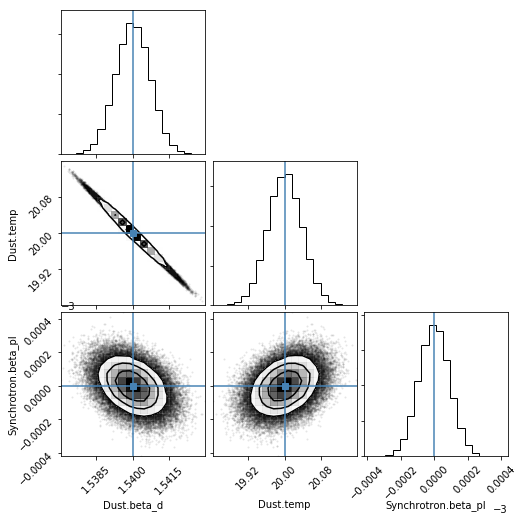

In [13]:
corner_norm(result.x, result.Sigma, labels=result.params, truths=inputs)

The amplitudes of the components are stacked in the `s` attribute and they are in the same format of the input frequency maps: Q and U healpix maps, in this case.

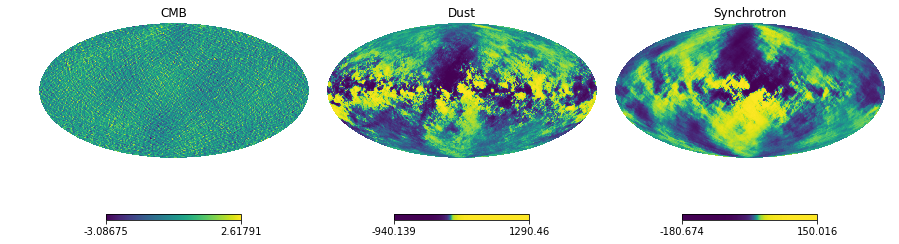

In [14]:
hp.mollview(result.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

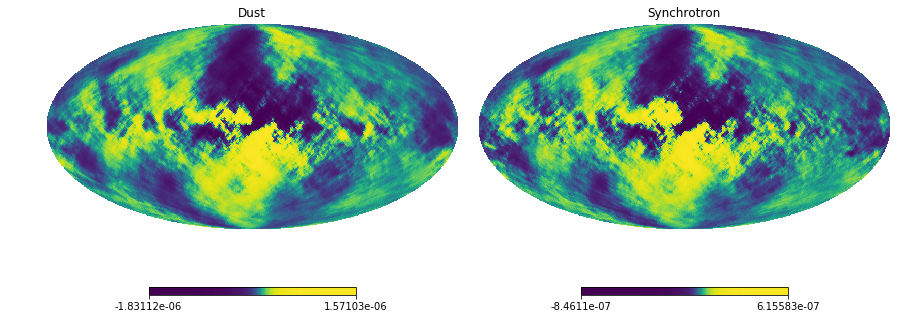

In [15]:
hp.mollview(result.s[1,1] - 
            sky_conf_simple['dust'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 353.),
            title='Dust', norm='hist', sub=(1,2,1))
hp.mollview(result.s[2,1] - 
            sky_conf_simple['synchrotron'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 23.), 
            title='Synchrotron', norm='hist', sub=(1,2,2))

## Component separation with varying indices
We now fit the spectral parameters independently over patches corresponding to healpix pixels with a given nside

In [16]:
nside_fit = 8#NSIDE_PATCH
result_vary = basic_comp_sep(components, instrument, freq_maps_vary, nside_fit)

The amplitudes of the components are stacked in the `s` attribute and they are in the same format of the input frequency maps: Q and U healpix maps, in this case.

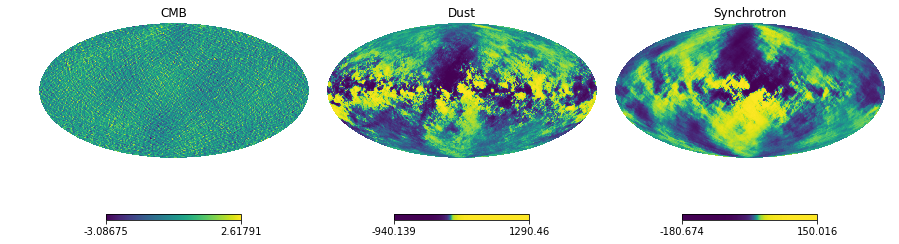

In [17]:
hp.mollview(result_vary.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_vary.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_vary.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

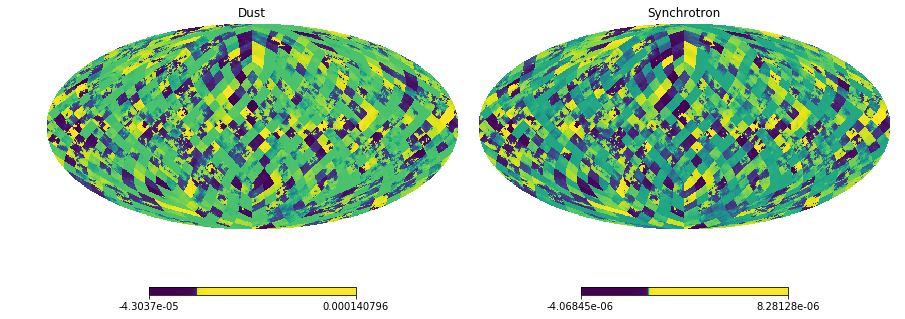

In [18]:
hp.mollview(result_vary.s[1,1] - 
            sky_conf_vary['dust'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 353.),
            title='Dust', norm='hist', sub=(1,2,1))
hp.mollview(result_vary.s[2,1] - 
            sky_conf_vary['synchrotron'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 23.), 
            title='Synchrotron', norm='hist', sub=(1,2,2))

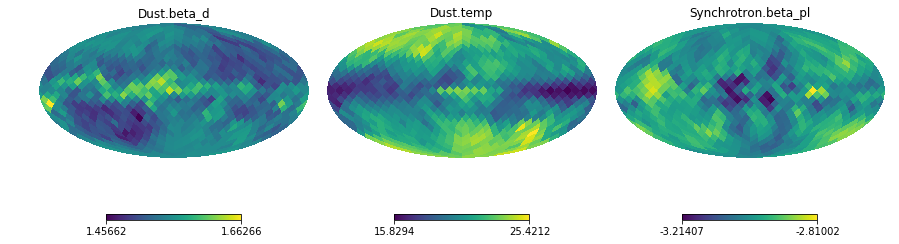

In [19]:
for i, par in enumerate(result.params):
    hp.mollview(result_vary.x[i], title=par, sub=(1,3,i+1))

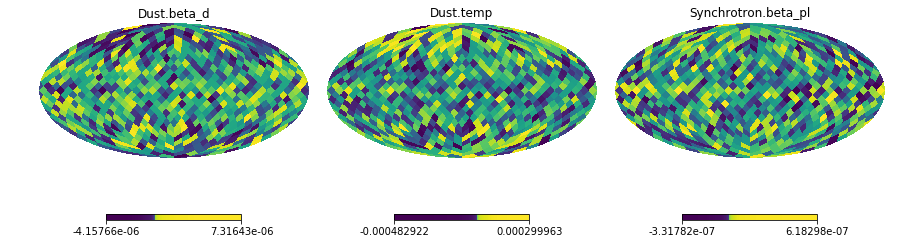

In [20]:
hp.mollview(hp.ud_grade(result_vary.x[0], NSIDE) - 
            sky_conf_vary['dust'][0]['spectral_index'],
            title=result.params[0], norm='hist', sub=(1,3,1))
hp.mollview(hp.ud_grade(result_vary.x[1], NSIDE) - 
            sky_conf_vary['dust'][0]['temp'],
            title=result.params[1], norm='hist', sub=(1,3,2))
hp.mollview(hp.ud_grade(result_vary.x[2], NSIDE) - 
            sky_conf_vary['synchrotron'][0]['spectral_index'],
            title=result.params[2], norm='hist', sub=(1,3,3))

# Extra about `Componenet`s

In [21]:
from fgbuster import AnalyticComponent
from scipy import constants

In [22]:
freq = instrument.Frequencies
beta = result_vary.x[0]
temp = result_vary.x[1]

In [23]:
analytic_expr = ('(exp(nu0 / temp * h_over_k) -1)'
                 '/ (exp(nu / temp * h_over_k) - 1)'
                 '* (nu / nu0)**(1 + beta_d)')
h_over_k_val = constants.h * 1e9 / constants.k

In [24]:
comp = AnalyticComponent(analytic_expr,
                         h_over_k=h_over_k_val,
                         nu0=353.,
                         beta_d=1.6,
                         temp=20.)

In [25]:
comp.eval(freq)

array([0.015545  , 0.0293815 , 0.04599306, 0.14535586, 0.17152282,
       0.31684787, 0.34807279, 0.56055079, 0.72833137])

In [26]:
comp_free = AnalyticComponent(analytic_expr,
                              h_over_k=h_over_k_val,
                              nu0=353.)

In [27]:
comp_free.params

['beta_d', 'temp']

In [28]:
sed = comp_free.eval(freq, beta, temp)
sed.shape

(768, 9)

In [29]:
comp_free.diff(freq, 1.6, 20.)

[array([-0.04462559, -0.07243335, -0.10015397, -0.20696011, -0.22513934,
        -0.28191042, -0.28647885, -0.26505112, -0.19522638]),
 array([-0.00035632, -0.0006555 , -0.00099774, -0.00274123, -0.00312442,
        -0.00473026, -0.00496267, -0.00548072, -0.00451333])]

In [30]:
dust = Dust(353., units='K_RJ')

In [31]:
import numpy as np
np.allclose(sed, 
            dust.eval(freq, beta, temp)
           )

True